In [1]:
import pandas as pd
import numpy as np
import pickle
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool,ColumnDataSource,TapTool

from sklearn.preprocessing import MinMaxScaler as minmax

from bokeh.models.callbacks import CustomJS
from bokeh.io import curdoc
from bokeh import events

from bokeh.layouts import row,column,layout,widgetbox
from bokeh.palettes import Category10
from bokeh.models import LinearInterpolator
from bokeh.models.mappers import LinearColorMapper
from bokeh.models.widgets import Slider

import matplotlib.pyplot as plt

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
#read all csvs
from os import listdir

def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

def get_epoch_number(filename):
    start_=14
    end_=filename.find('.')
    #print(filename[start_:end_])
    return int(filename[start_:end_])

def update_df(df):
    images_df=df.iloc[:,:-3]
    images=images_df.as_matrix().astype(np.float64)
    images=minmax().fit_transform(images)

    images_list=[]
    for i in range(images.shape[0]):
        images_list.append(np.flip(images[i,:].reshape(28,28),axis=0))

    xs=np.random.random((len(images_list))).tolist()
    ys=np.random.random((len(images_list))).tolist()    

    df['xs']=xs
    df['ys']=ys
    df['images']=images_list
    return df

csv_files=find_csv_filenames('./')
epoch_numbers=list(map(get_epoch_number,csv_files))

epoch_df_dict={}
for i in range(len(csv_files)):
    df=pd.read_csv(csv_files[i])
    df=update_df(df)     
    epoch_df_dict[epoch_numbers[i]]=df 
    
#use the first epoch    
df=epoch_df_dict[0]

In [4]:
accuracy=np.mean(df['label']==df['preds'])
accuracy

0.89510000000000001

In [5]:
df['images'][100].shape

(28, 28)

In [6]:
first_df=df.loc[df['label']==1,:]
first_df.reset_index(inplace=True)
first_df.shape,Category10[10]

((1000, 791),
 ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22',
  '#17becf'])

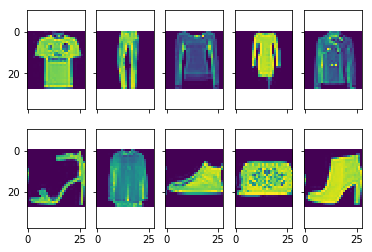

In [7]:
f, axarr = plt.subplots(2,5,sharex=True,sharey=True)
for i in range(2):
    for j in range(5):
        first_df=df.loc[df['label']==(i*5+j),:]
        first_df.reset_index(inplace=True)
        image_=np.flip(first_df.loc[0,'images'].reshape(28,28),axis=0)
        axarr[i,j].imshow(image_)
plt.show()        

In [8]:
first_df=df.loc[df['label']==1,:]
first_df.reset_index(inplace=True)
data_source=ColumnDataSource(data=dict(xs=[],ys=[],color=[],\
                                       size=[],images=[]))

images_source=ColumnDataSource(data=dict(images=[]))

scatter_plot=None
img=None
slider=None
slider2=None
slider3=None

def update_plot(attr,old,new):
    global slider,slider2,df,data_source
    filtered=df.loc[df['preds']==slider.value,:]
    filtered=filtered.loc[filtered['label']==slider2.value,:]
    filtered.reset_index(inplace=True)
    
    data_source.data['xs']=filtered['xs']
    data_source.data['ys']=filtered['ys']
    data_source.data['color']=filtered['preds']
    data_source.data['size']=filtered['label']
    data_source.data['images']=filtered['images']
    
def update_plot2(attr,old,new):
    global slider,slider2,df,data_source
    filtered=df.loc[df['label']==slider2.value,:]
    filtered=filtered.loc[filtered['preds']==slider.value,:]
    filtered.reset_index(inplace=True)
        
    data_source.data['xs']=filtered['xs']
    data_source.data['ys']=filtered['ys']
    data_source.data['color']=filtered['preds']
    data_source.data['size']=filtered['label'] 
    data_source.data['images']=filtered['images']
    
def update_plot3(attr,old,new):
    global slider,slider2,slider3,df,data_source,epoch_df_dict,images_source,scatter_plot
    #change the global df
    df=epoch_df_dict[slider3.value]
    filtered=df.loc[df['label']==slider2.value,:]
    filtered=filtered.loc[filtered['preds']==slider.value,:]
    filtered.reset_index(inplace=True)
     
    images_source.data['images']=[]
    scatter_plot.title.text='Basic RNN Fashion MNISt acc:{0} %'.format(np.mean(df['label']==\
                                                                               df['preds'])%100)
    data_source.data['xs']=filtered['xs']
    data_source.data['ys']=filtered['ys']
    data_source.data['color']=filtered['preds']
    data_source.data['size']=filtered['label'] 
    data_source.data['images']=filtered['images']    
    
tap_callback = CustomJS(args=dict(source=data_source,source2=images_source),code="""
        var selected = source.selected['1d'].indices;
        console.log(cb_data.source,cb_data.geometries,selected[0]);
        var data =cb_data.source['data'];
        var data2=source2['data'];
        var ind0 =selected[0];
        var arr=data['images'][ind0]
        var newArr = [];
        while(arr.length) 
            newArr.push(arr.splice(0,28));             
             data2['images']=newArr;       
             source2.change.emit();
    """)


slider = Slider(start=0, end=9, value=1, step=1, title="Predicted class")
slider.on_change('value', update_plot)

slider2 = Slider(start=0, end=9, value=1, step=1, title="True class")
slider2.on_change('value', update_plot2)

slider3 = Slider(start=0, end=epoch_numbers[-1], value=0, step=10, title="Select epoch numbers")
slider3.on_change('value', update_plot3)

hover=HoverTool(tooltips=[('Pred:',"@color"),\
                          ('TrueLabel:','@size')],show_arrow=False)

tap=TapTool(callback=tap_callback)

size_mapper=LinearInterpolator(x=[0,9],\
      y=[5,15])

color_mapper=LinearColorMapper(low=0,\
                               high=9,\
                              palette=Category10[10])

scatter_plot=figure(toolbar_location='above',plot_width=600,plot_height=500,title='Fashion Mnist Basic RNN')
scatter_plot.circle('xs','ys',source=data_source,fill_color={'field':'color','transform':color_mapper},\
                    size={'field':'size','transform':size_mapper})

#add js event click.
scatter_plot.add_tools(hover)
scatter_plot.add_tools(tap)
#scatter_plot.js_on_event(events.Tap,hover_callback) 

img = figure(x_range=(0,10),y_range=(0,10),tools=['hover'], toolbar_location='above',plot_width=600,plot_height=500)
img.image(image='images', x=0, y=0, dw=10, dh=10,palette='Greys7',source=images_source)
img.axis.visible=False
l=column(row(scatter_plot,img),row(widgetbox(slider,slider2)),widgetbox(slider3))
curdoc().add_root(l)
show(l)
#plt.imshow(images[1,:].reshape(28,28),cmap='gray')
#plt.show()

In [17]:
#make plots for loss history and how accuracy changes every 10 epochs.
epoch_losses=[0.289944167081,0.259366312387,0.236004968882,0.217045344887,0.200112893094,
0.184509267483,0.170370121066,0.157026038341,0.143694052134,0.130701434189,
0.118463783008,0.107302485404,0.0959990895673,0.0860506446978,0.0773995148988,
0.06890464646,0.0623749301933,0.0578747882545,0.0513374666165,0.0473809144974,
0.0438825384018,0.0409800745775,0.0401293693612,0.0320133453478,0.0355159673595,0.0311654857328,0.0269695229912,0.0262712578272,0.0221014949802,0.0192534293109,
0.0202305030892,0.0200851756737,0.0183614537309]

num_losses=list(range(len(epoch_losses)))

train_acc_every10_epochs=[0.894883,0.9525,0.974017,0.9831,0.985017]
test_acc_every10_epochs=[0.8951,0.9216,0.9216,0.9203,0.9205]
num_acc=list(range(len(train_acc_every10_epochs)))

plot1=figure(toolbar_location='above',plot_width=400,plot_height=400,title='Fashion Mnist Train losses')
plot1.line(num_losses,epoch_losses)

plot2=figure(toolbar_location='above',plot_width=500,plot_height=400,title='Fashion Mnist Train Vs Test Accuracy')
plot2.line(num_acc,train_acc_every10_epochs)
plot2.line(num_acc,test_acc_every10_epochs)

l2=row(plot1,plot2)
curdoc().add_root(l2)
show(l2)